In [1]:
%pylab inline
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from pandas import concat, DataFrame
import seaborn as sns
plt.style.use('ggplot')
import logging
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
 

Populating the interactive namespace from numpy and matplotlib


# Project: Blood glucose prediction with neural network
# Author: Martin Nanchev

The idea behind the project is to explore the opportunity to use neuronal network to predict blood glucose, based on historical values. Machine learning models were tested and developed and have acceptable accuracy - https://github.com/mnanchev/blood_glucose_ml_modells
This paper analyze the same topic, but with the help of Deep Learning using Tensorflow

## 1 Read and clean data Exploratory data analysis

The dataset would be cleaned and visualized. After that it will be downsampled, scaled between 0 and 1 using MinMaxScaler. The last step is to determine the number of lags and shift the dataset.

In [2]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1,
                          write_graph=True, write_images=True)
blood_glucose_dataset = pd.read_excel("./blood_sugar_data_complete.xls")
blood_glucose_dataset.drop(["BASAL_TS","BOLUS_TS"],axis=1,inplace=True)

In [3]:
blood_glucose_dataset.shape

(4613, 2)

In [4]:
blood_glucose_dataset

,DATETIME,BLOOD_GLUCOSE
0,2020-10-11 16:00:00,3.6
1,2020-10-11 16:05:00,3.7
2,2020-10-11 16:10:00,3.7
3,2020-10-11 16:15:00,3.7
4,2020-10-11 16:20:00,4.1
...,...,...
4608,2020-10-25 18:28:00,6.9
4609,2020-10-25 18:28:00,6.9
4610,2020-10-25 18:29:00,6.9
4611,2020-10-25 18:30:00,6.9


In [5]:
def plot_line_chart(x, y = pd.Series([]), figsize = (10,5), title = "", xlabel = "", ylabel= ""):
    if not(x.empty) and not(y.empty):
        plt.figure(figsize=figsize)
        plt.fill_between( x, y, color="skyblue", alpha=0.3)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.plot(x, y, color="skyblue")
    elif not(x.empty):
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.plot(x, color="skyblue")
       

def downsample(dataset, index, column,  period = "30min"):
    dataset.set_index(index, inplace=True)
    time_series = dataset[column].resample(period).mean()
    return time_series

def min_max_scaling(dataset, min, max, column, index):
    dataset = dataset.reset_index()
    dataset[column]=tf.math.divide(tf.math.subtract(blood_glucose_time_series,np.float64(min)),  tf.math.subtract(np.float64(max),np.float64(min)))
    dataset.set_index(index, inplace=True)
    return dataset

def inverse_min_max_scaling(dataset, min, max):
	inverse_min_max_scaler = np.add(np.multiply((np.subtract(max, min)),dataset),min)
	return inverse_min_max_scaler

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def train_test_split(dataset, size=0.67):
	train_size = int(len(dataset) * size)
	test_size = len(dataset) - train_size
	train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
	return (train, test)

def scheduler(epoch, lr):
	if epoch < 10:
		return lr
	else:
		return lr * tf.math.exp(-0.1)

def create_model(architecture, trainX, trainY, testX, testY, loss='mean_squared_error', optimizer='adam',model_name="",patience=5):
	model = tf.keras.Sequential(architecture)
	model.compile(loss=loss, optimizer=optimizer)
	es = EarlyStopping(monitor='val_loss', mode='auto', patience=patience, restore_best_weights=True)
	history = model.fit(trainX, trainY, validation_data=(testX, testY) ,epochs=100, batch_size=1,callbacks=[es, tensorboard],verbose=2)
	model.summary()
	model.save(model_name)
	if not ("encoder" in model_name):
		trainPredict = model.predict(trainX)
		testPredict = model.predict(testX)
		trainPredict = inverse_min_max_scaling(trainPredict, 1.0, 36)
		trainY_inverse = inverse_min_max_scaling(trainY, 1.0, 36)
		testPredict = inverse_min_max_scaling(testPredict, 1.0, 36)
		testY_inverse  = inverse_min_max_scaling(testY, 1.0, 36)
		# calculate root mean squared error
		trainScore = math.sqrt(mean_squared_error(trainY_inverse, trainPredict))
		print('Train Score: %.2f RMSE' % (trainScore))
		testScore = math.sqrt(mean_squared_error(testY_inverse, testPredict))
		print('Test Score: %.2f RMSE' % (testScore))
		plt.xlabel("points in time")
		plt.ylabel("mmol/dL")
		plt.plot(testPredict)
		plt.plot(np.array(testY_inverse))
		plt.show()
		r2 = r2_score(np.array(testY_inverse), testPredict)
		print("R squared for the test score: ",r2)
		plt.plot(history.history['loss'])
		plt.plot(history.history['val_loss'])
		plt.title('model loss')
		plt.ylabel('loss')
		plt.xlabel('epoch')

		plt.show()
	else:
		testPredict = model.predict(testX)
		testY_inverse  = inverse_min_max_scaling(testY, 2.2, 36)
		mean_value = [(values[0] + values[1])/2.0 for values in testPredict]
		mean_value = inverse_min_max_scaling(mean_value, 2.2, 36)
		plt.xlabel("points in time")
		plt.ylabel("mmol/dL")
		plt.plot(mean_value)
		plt.plot(np.array(testY_inverse))
		plt.show()
		r2 = r2_score(np.array(testY_inverse), mean_value)
		print("R squared for the test score: ",r2)
		plt.plot(history.history['loss'])
		plt.plot(history.history['val_loss'])
		plt.title('model loss')
		plt.ylabel('loss')
		plt.xlabel('epoch')
		plt.show()
	return model


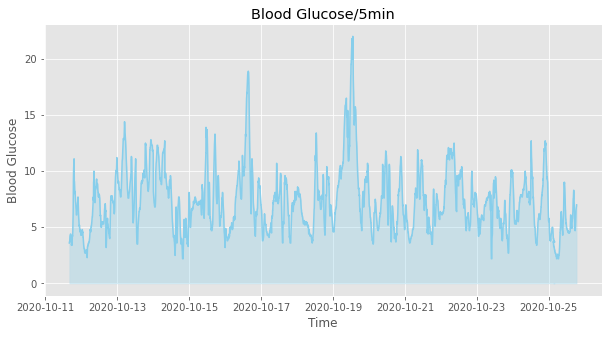

In [6]:
plot_line_chart(blood_glucose_dataset.DATETIME, blood_glucose_dataset.BLOOD_GLUCOSE, title = "Blood Glucose/5min", xlabel = "Time", ylabel = "Blood Glucose")

### 1.1 Nyquist Theorem

To present a signal with frequency of B, a samples rate of 2B/s will be required or:
If a function x(t) contains no frequencies higher than B hertz, it is completely determined by giving its ordinates at a series of points spaced $$ \frac{1}{2B} $$ 
seconds apart.

In blood glucose, we will need 6 samples to downsample to 30 minutes


In [7]:
blood_glucose_time_series = downsample(dataset=blood_glucose_dataset,column="BLOOD_GLUCOSE", index="DATETIME")

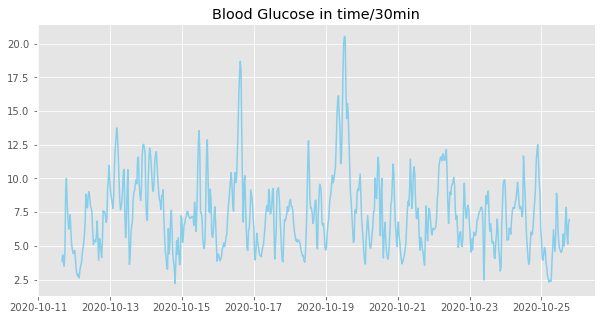

In [8]:
plot_line_chart(blood_glucose_time_series, title = "Blood Glucose in time/30min")

### 1.2 Scaling the data after downsampling

Neural networks require the features to be scaled for best performance. A min max scaler will be used for this purpose

$$ x'={\frac  {x-{\text{min}}(x)}{{\text{max}}(x)-{\text{min}}(x)}} $$

In [9]:
blood_glucose_time_series_scaled = min_max_scaling(blood_glucose_time_series,1.0,36.0,"BLOOD_GLUCOSE","DATETIME")

### 1.3 Transforming from time series to supervised learning problem 
To transform timeseries to supervised learning problem the features will be shifted by a lag of 5. The last column will be the label and all others will be the features matrix. This means, that we will lose 5 elements for which we don't have historical values. 

In [10]:
blood_glucose_time_series_scaled_to_supervised = series_to_supervised(blood_glucose_time_series_scaled,5)

### 1.4 Split the dataset in testing and training

In [11]:
train, test = train_test_split(blood_glucose_time_series_scaled_to_supervised , size=0.67)

### 1.5 Planing of the model creation and defining labels and features

1. Vanilla LSTM
2. Stacked LSTM
3. Bidirectional LSTM
4. CNN LSTM
5. ConvLSTM
6. Multi-Step LSTM using Encoder-Decoder Model


#### 1.5.1 Long short-term memory is an artificial recurrent neural network, which acts like state machine and uses features and state as input:

<img src="The_LSTM_Cell.png" width="200" height="200"/>

The image show the LSTM neuron cosist of:

- Forget gates - which decides what to keep and what to throw away at time t-1
- Input gate - accepts input values at time t-1 and updates the state
- Output gate - determines the output based on the state and input.

 \begin{aligned}f_{t}&=\sigma _{g}(W_{f}x_{t}+U_{f}h_{t-1}+b_{f})\\i_{t}&=\sigma _{g}(W_{i}x_{t}+U_{i}h_{t-1}+b_{i})\\o_{t}&=\sigma _{g}(W_{o}x_{t}+U_{o}h_{t-1}+b_{o})\\{\tilde {c}}_{t}&=\sigma _{c}(W_{c}x_{t}+U_{c}h_{t-1}+b_{c})\\c_{t}&=f_{t}\circ c_{t-1}+i_{t}\circ {\tilde {c}}_{t}\\h_{t}&=o_{t}\circ \sigma _{h}(c_{t})\end{aligned}

 #### 1.5.2 Convolutional neural network 

Convolutional neural network applies filters using operation called convolution, which extract features from images, scene:

<img src="CNN.png" width="600" height="200"/>

The convolution is defined by:

$$ (f*g)(t):=\int _{-\infty }^{\infty }f(\tau )g(t-\tau )\,d\tau $$



In [12]:

trainY = train["var1(t)"]
trainX = train.drop(["var1(t)"], axis=1)
trainX = np.reshape(trainX.to_numpy(), (trainX.to_numpy().shape[0], 1, trainX.to_numpy().shape[1]))


testY = test["var1(t)"]
testX = test.drop(["var1(t)"], axis=1)
testX = np.reshape(testX.to_numpy(), (testX.to_numpy().shape[0], 1, testX.to_numpy().shape[1]))

## 2 Building Deep learning models

### 2.1 Vanilla LSTM

Epoch 1/100
450/450 - 3s - loss: 0.0103 - val_loss: 0.0034
Epoch 2/100
450/450 - 1s - loss: 0.0040 - val_loss: 0.0023
Epoch 3/100
450/450 - 1s - loss: 0.0027 - val_loss: 0.0016
Epoch 4/100
450/450 - 1s - loss: 0.0021 - val_loss: 0.0016
Epoch 5/100
450/450 - 1s - loss: 0.0018 - val_loss: 0.0012
Epoch 6/100
450/450 - 1s - loss: 0.0017 - val_loss: 0.0016
Epoch 7/100
450/450 - 1s - loss: 0.0016 - val_loss: 0.0011
Epoch 8/100
450/450 - 1s - loss: 0.0015 - val_loss: 0.0011
Epoch 9/100
450/450 - 1s - loss: 0.0015 - val_loss: 0.0011
Epoch 10/100
450/450 - 1s - loss: 0.0014 - val_loss: 0.0010
Epoch 11/100
450/450 - 1s - loss: 0.0014 - val_loss: 0.0010
Epoch 12/100
450/450 - 1s - loss: 0.0014 - val_loss: 0.0010
Epoch 13/100
450/450 - 1s - loss: 0.0014 - val_loss: 0.0011
Epoch 14/100
450/450 - 1s - loss: 0.0014 - val_loss: 0.0010
Epoch 15/100
450/450 - 1s - loss: 0.0013 - val_loss: 0.0010
Epoch 16/100
450/450 - 1s - loss: 0.0014 - val_loss: 9.7767e-04
Epoch 17/100
450/450 - 1s - loss: 0.0013 - va

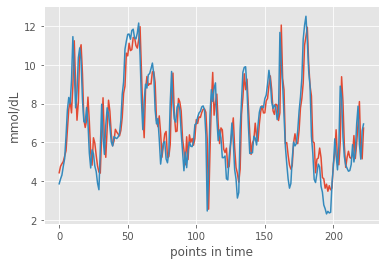

R squared for the test score:  0.7830741644365719


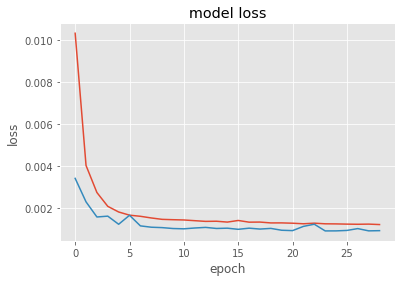

In [13]:
vanilla_lstm_architecture = [
  layers.LSTM(2,input_shape=(1, 5
  )),
  layers.Dense(1)
]

vanilla_lstm_model = create_model(vanilla_lstm_architecture, trainX, trainY, testX, testY, model_name="vanilla", patience=5)


### 2.2 Stacked LSTM

The LSMT layer with two neurons will return a full sequence to the next LSTM layer.
Transfer learning is the process of tranfering layers of trained neural network to new architecture to reduce the learning time and improve the overall results. We will transfer the already trained layer from the vanilla modell to the Stacked LSTM and see if the result improves in comparison with the Stacked LSTM, trained from the beginning.

#### 2.2.1 Stacked LSTM with randomly initialized weights

In [14]:
transfer_learning_layers = None
for i, layer in enumerate(vanilla_lstm_model.layers):
  layer.trainable = False
  if "lstm" in layer.name:
      print("Initial return sequence of vanilla lstm: ",layer.return_sequences )
      layer.return_sequences = True
      transfer_learning_layers = layer
  print(i, layer.name)

print("Return sequence after augmentation: ",vanilla_lstm_model.layers[0].return_sequences )

Initial return sequence of vanilla lstm:  False
0 lstm
1 dense
Return sequence after augmentation:  True


Epoch 1/100
450/450 - 4s - loss: 0.0083 - val_loss: 0.0033
Epoch 2/100
450/450 - 1s - loss: 0.0050 - val_loss: 0.0027
Epoch 3/100
450/450 - 1s - loss: 0.0042 - val_loss: 0.0030
Epoch 4/100
450/450 - 1s - loss: 0.0036 - val_loss: 0.0022
Epoch 5/100
450/450 - 1s - loss: 0.0034 - val_loss: 0.0022
Epoch 6/100
450/450 - 1s - loss: 0.0031 - val_loss: 0.0019
Epoch 7/100
450/450 - 1s - loss: 0.0028 - val_loss: 0.0019
Epoch 8/100
450/450 - 1s - loss: 0.0026 - val_loss: 0.0017
Epoch 9/100
450/450 - 1s - loss: 0.0024 - val_loss: 0.0015
Epoch 10/100
450/450 - 1s - loss: 0.0022 - val_loss: 0.0014
Epoch 11/100
450/450 - 1s - loss: 0.0020 - val_loss: 0.0015
Epoch 12/100
450/450 - 1s - loss: 0.0019 - val_loss: 0.0012
Epoch 13/100
450/450 - 1s - loss: 0.0018 - val_loss: 0.0011
Epoch 14/100
450/450 - 1s - loss: 0.0016 - val_loss: 0.0011
Epoch 15/100
450/450 - 1s - loss: 0.0016 - val_loss: 0.0010
Epoch 16/100
450/450 - 1s - loss: 0.0015 - val_loss: 0.0010
Epoch 17/100
450/450 - 1s - loss: 0.0014 - val_lo

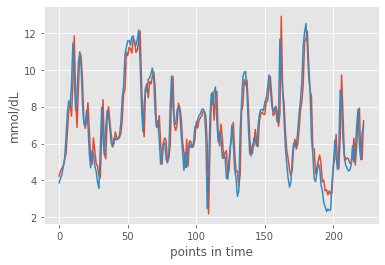

R squared for the test score:  0.8108421794612443


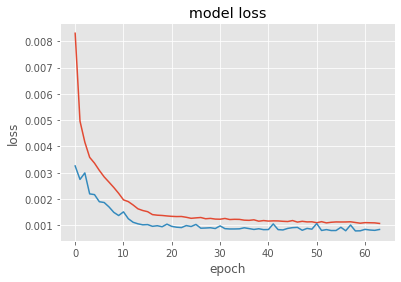

In [15]:

stacked_lstm_architecture = [
  layers.LSTM(2,input_shape=(1, 5
  ),return_sequences=True),
  layers.LSTM(2,input_shape=(1, 5
  )),
  layers.Dense(1)
]

stacked_lstm_model = create_model(stacked_lstm_architecture, trainX, trainY, testX, testY, model_name="stacked_lstm",patience=5)

#### 2.2.2 Stacked LSTM using input layer from the vanilla model

Epoch 1/100
450/450 - 4s - loss: 0.0131 - val_loss: 0.0039
Epoch 2/100
450/450 - 1s - loss: 0.0066 - val_loss: 0.0039
Epoch 3/100
450/450 - 1s - loss: 0.0060 - val_loss: 0.0034
Epoch 4/100
450/450 - 1s - loss: 0.0055 - val_loss: 0.0034
Epoch 5/100
450/450 - 1s - loss: 0.0048 - val_loss: 0.0028
Epoch 6/100
450/450 - 1s - loss: 0.0042 - val_loss: 0.0031
Epoch 7/100
450/450 - 1s - loss: 0.0035 - val_loss: 0.0021
Epoch 8/100
450/450 - 1s - loss: 0.0030 - val_loss: 0.0018
Epoch 9/100
450/450 - 1s - loss: 0.0024 - val_loss: 0.0014
Epoch 10/100
450/450 - 1s - loss: 0.0019 - val_loss: 0.0012
Epoch 11/100
450/450 - 1s - loss: 0.0015 - val_loss: 0.0011
Epoch 12/100
450/450 - 1s - loss: 0.0014 - val_loss: 0.0010
Epoch 13/100
450/450 - 1s - loss: 0.0013 - val_loss: 9.1140e-04
Epoch 14/100
450/450 - 1s - loss: 0.0013 - val_loss: 9.0959e-04
Epoch 15/100
450/450 - 1s - loss: 0.0012 - val_loss: 9.7505e-04
Epoch 16/100
450/450 - 1s - loss: 0.0013 - val_loss: 9.1642e-04
Epoch 17/100
450/450 - 1s - loss:

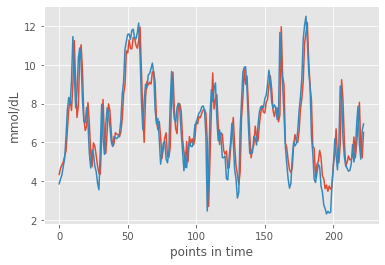

R squared for the test score:  0.7864472504518027


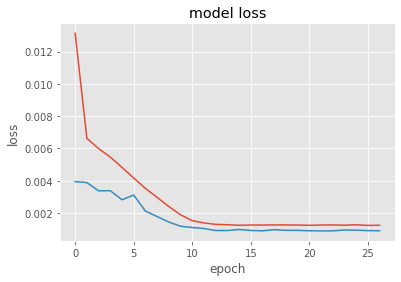

In [16]:
stacked_lstm_architecture_with_transfer_learning = [
  transfer_learning_layers,
  layers.LSTM(2,input_shape=(1, 5
  )),
  layers.Dense(1)
]

stacked_lstm_model = create_model(stacked_lstm_architecture_with_transfer_learning, trainX, trainY, testX, testY, model_name="stacked_lstm_with_transfer_learning", patience=5)

### 2.3 Bidirectional LSTM

Epoch 1/100
450/450 - 4s - loss: 0.0086 - val_loss: 0.0024
Epoch 2/100
450/450 - 1s - loss: 0.0027 - val_loss: 0.0016
Epoch 3/100
450/450 - 1s - loss: 0.0021 - val_loss: 0.0013
Epoch 4/100
450/450 - 1s - loss: 0.0019 - val_loss: 0.0013
Epoch 5/100
450/450 - 1s - loss: 0.0019 - val_loss: 0.0012
Epoch 6/100
450/450 - 1s - loss: 0.0019 - val_loss: 0.0012
Epoch 7/100
450/450 - 1s - loss: 0.0018 - val_loss: 0.0012
Epoch 8/100
450/450 - 1s - loss: 0.0017 - val_loss: 0.0012
Epoch 9/100
450/450 - 1s - loss: 0.0017 - val_loss: 0.0011
Epoch 10/100
450/450 - 1s - loss: 0.0016 - val_loss: 0.0011
Epoch 11/100
450/450 - 1s - loss: 0.0016 - val_loss: 0.0011
Epoch 12/100
450/450 - 1s - loss: 0.0016 - val_loss: 0.0011
Epoch 13/100
450/450 - 1s - loss: 0.0016 - val_loss: 0.0011
Epoch 14/100
450/450 - 1s - loss: 0.0015 - val_loss: 0.0011
Epoch 15/100
450/450 - 1s - loss: 0.0015 - val_loss: 0.0011
Epoch 16/100
450/450 - 1s - loss: 0.0015 - val_loss: 0.0011
Epoch 17/100
450/450 - 1s - loss: 0.0015 - val_lo

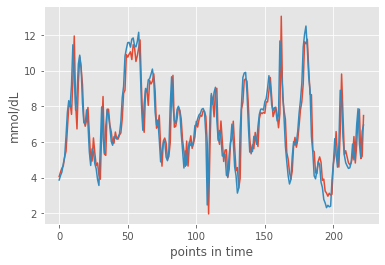

R squared for the test score:  0.8170168206306483


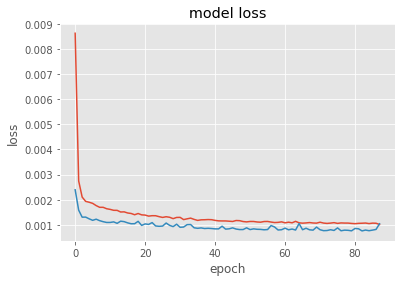

In [17]:
bidirectional_lstm_architecture = [
  layers.Bidirectional(layers.LSTM(2), input_shape=(1, 5
  )),
  layers.Dense(1)
]

bidirectional_lstm_model = create_model(bidirectional_lstm_architecture, trainX, trainY, testX, testY, model_name="bidirectional_lstm", patience=5)

#### 2.3.1 Bidirectional LSTM with transfer learning

Epoch 1/100
450/450 - 4s - loss: 0.0010 - val_loss: 7.6995e-04
Epoch 2/100
450/450 - 1s - loss: 0.0011 - val_loss: 7.6130e-04
Epoch 3/100
450/450 - 1s - loss: 0.0010 - val_loss: 8.2239e-04
Epoch 4/100
450/450 - 1s - loss: 0.0011 - val_loss: 8.4496e-04
Epoch 5/100
450/450 - 1s - loss: 0.0011 - val_loss: 7.8299e-04
Epoch 6/100
450/450 - 1s - loss: 0.0010 - val_loss: 7.6564e-04
Epoch 7/100
450/450 - 1s - loss: 0.0011 - val_loss: 7.5489e-04
Epoch 8/100
450/450 - 1s - loss: 0.0011 - val_loss: 8.4360e-04
Epoch 9/100
450/450 - 1s - loss: 0.0010 - val_loss: 8.3496e-04
Epoch 10/100
450/450 - 1s - loss: 0.0010 - val_loss: 8.8427e-04
Epoch 11/100
450/450 - 1s - loss: 0.0011 - val_loss: 9.2225e-04
Epoch 12/100
450/450 - 1s - loss: 0.0011 - val_loss: 7.6383e-04
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 4)                 128       
_____________________

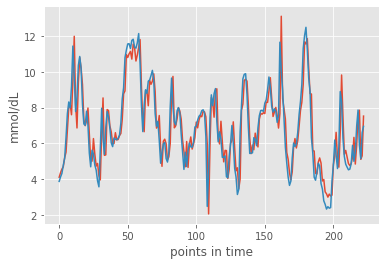

R squared for the test score:  0.8182778805388795


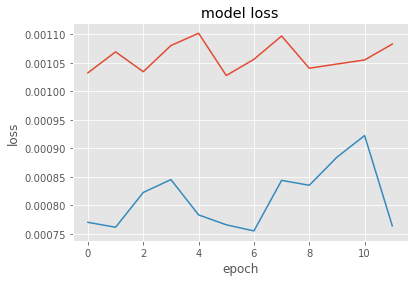

In [18]:
bidirectional_lstm_architecture_with_transfer_learning = [
  layers.Bidirectional(transfer_learning_layers,input_shape=(1, 5
  )),
  layers.Dense(1)
]

bidirectional_lstm_model_with_transfer_learning = create_model(bidirectional_lstm_architecture, trainX, trainY, testX, testY, model_name="bidirectional_lstm_with_transfer_learning", patience=5)

### 2.4 Encoder-Decoder model

Epoch 1/100
450/450 - 4s - loss: 0.0119 - val_loss: 0.0045
Epoch 2/100
450/450 - 1s - loss: 0.0065 - val_loss: 0.0036
Epoch 3/100
450/450 - 1s - loss: 0.0052 - val_loss: 0.0028
Epoch 4/100
450/450 - 1s - loss: 0.0041 - val_loss: 0.0024
Epoch 5/100
450/450 - 1s - loss: 0.0034 - val_loss: 0.0022
Epoch 6/100
450/450 - 1s - loss: 0.0032 - val_loss: 0.0019
Epoch 7/100
450/450 - 1s - loss: 0.0029 - val_loss: 0.0018
Epoch 8/100
450/450 - 1s - loss: 0.0027 - val_loss: 0.0017
Epoch 9/100
450/450 - 1s - loss: 0.0025 - val_loss: 0.0016
Epoch 10/100
450/450 - 1s - loss: 0.0024 - val_loss: 0.0015
Epoch 11/100
450/450 - 1s - loss: 0.0022 - val_loss: 0.0014
Epoch 12/100
450/450 - 1s - loss: 0.0021 - val_loss: 0.0013
Epoch 13/100
450/450 - 1s - loss: 0.0019 - val_loss: 0.0012
Epoch 14/100
450/450 - 1s - loss: 0.0018 - val_loss: 0.0011
Epoch 15/100
450/450 - 1s - loss: 0.0017 - val_loss: 0.0012
Epoch 16/100
450/450 - 1s - loss: 0.0016 - val_loss: 0.0010
Epoch 17/100
450/450 - 1s - loss: 0.0016 - val_lo

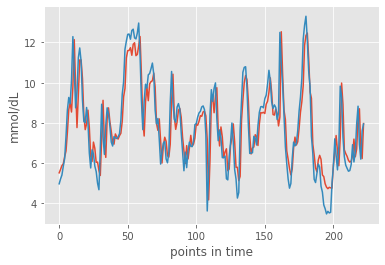

R squared for the test score:  0.7950949776444296


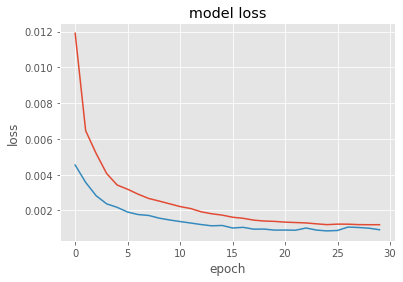

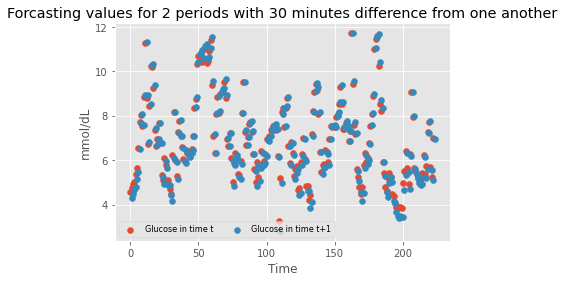

In [19]:
encoder_decoder_lstm_architecture = [
  layers.LSTM(2,input_shape=(1, 5
  )),
  layers.RepeatVector(2),
  layers.LSTM(2,input_shape=(1, 5
  ),return_sequences=True),
  layers.TimeDistributed(layers.Dense(1))
]

encoder_decoder_lstm_model = create_model(encoder_decoder_lstm_architecture, trainX, trainY, testX, testY, model_name="encoder_decoder_lstm", patience=5)
multiple_output_values = encoder_decoder_lstm_model.predict(testX)
initial_forecast = inverse_min_max_scaling([values[0] for values in multiple_output_values],1.0,36.0)
next_forecast = inverse_min_max_scaling([values[1] for values in multiple_output_values],1.0,36.0)
initial_forcast_index = [i for i in range(len(initial_forecast))]
next_forcast_index = [i+1 for i in range(len(initial_forecast))]
initial = plt.scatter(initial_forcast_index,initial_forecast)
next = plt.scatter(next_forcast_index,next_forecast)
plt.title('Forcasting values for 2 periods with 30 minutes difference from one another')
plt.xlabel('Time')
plt.ylabel('mmol/dL')

plt.legend((initial, next),
           ('Glucose in time t', 'Glucose in time t+1'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()